# How long does it really take to get the billet you want in Genshin Impact?

## The problem: a quick overview

When playing the video game Genshin Impact, you may run into the item known as a "billet". These items are used to craft weapons using other materials found in the world. There are 5 billet types within Genshin Impact, and each of them can be used to craft certain weapons. Each billet does have two forms, however we will do away with this for simplicity, as they can be converted between each other.

There are innumerable complaints about getting the billet-type you want in Genshin Impact, everyone seems to be getting only the billets that they don't want. So the question arises, mathematically, how likely is it for you to get the billet you want?

## Before we continue...

This analysis is statistical in nature, a Monte Carlo method is used, so let us continue with a brief overview of the Monte Carlo method, and the reason why it suits this study.

## Introduction to the Monte Carlo Method for Domain Drop Simulation

The Monte Carlo method is a powerful computational technique to model complex systems and processes influenced by random variables. It has applications in various fields, including finance, physics, engineering, and game development. In this notebook, we employ the Monte Carlo method to simulate and analyze the probabilistic nature of obtaining specific item drops (specifically, a claymore billet) in a game environment.

#### Law of Large Numbers

 **Law of Large Numbers** is heavily exploited when performing a Monte Carlo Simulation. This theorem states that the sample mean will converge to the expected value as the number of trials increases. Mathematically, if $X_1, X_2, \ldots, X_n$ are independent and identically distributed random variables with an expected value $\mu$, then:

$$
\bar{X}_n = \frac{1}{n} \sum_{i=1}^{n} X_i \rightarrow \mu \quad \text{as} \quad n \rightarrow \infty
$$

This principle assures that with enough simulations, the sample mean will provide a reliable estimate of the true mean, enabling accurate probabilistic predictions.

#### Bernoulli Trials

The simulation relies on Bernoulli trials, representing random experiments with two possible outcomes: success or failure. Each trial is independent, with a constant probability of success. A Bernoulli random variable $X$ can be defined as:

$$
P(X = 1) = p \quad \text{and} \quad P(X = 0) = 1 - p
$$

In this context, a domain run is modelled as a Bernoulli trial, where success corresponds to obtaining a billet drop.

### Simulation Framework

#### Step 1: Define Parameters and Probabilities

The simulation establishes key parameters and probabilities that influence the Monte Carlo process. These parameters mimic in-game mechanics and player actions:

- **Resin Mechanics:**
  - `RESIN_PER_DAY = 180`: Daily resin accumulation, a resource critical for determining domain run attempts.
  - `TOTAL_RESIN_NEEDED`: Total resin required for nine weekly domain runs, divided into two groups with different resin costs (90 for the first three and 360 for the next six runs).

- **Event Probabilities:**
  - `PROB_BILLET_DROP = 0.12`: Probability of any billet dropping after a domain run.
  - `PROB_CLAYMORE_BILLET = 0.2`: Probability of acquiring a claymore billet given a billet drop, assuming equal chances among five types.

#### Step 2: Simulate Weekly Domain Runs

The notebook simulates weekly domain attempts based on the defined parameters:

- **Weekly Iterations:**
  - For each week, resin accumulates and is spent on domain runs.
  - Each domain attempt is an independent Bernoulli trial with outcomes determined by random sampling, reflecting the stochastic nature of drops.

#### Step 3: Monte Carlo Simulations

The Monte Carlo method involves multiple simulations to capture system variability and randomness. Here, the notebook conducts `NUM_SIMULATIONS = 10000` iterations:

- **Simulation Loop:**
  - Track the weeks required to obtain a claymore billet in each simulation.
  - Aggregate results to form a distribution of weeks needed.

#### Step 4: Result Aggregation and Analysis

Upon completing the simulations, the results are analyzed statistically:

- **Descriptive Statistics:**
  - Calculate the average number of weeks needed to obtain a claymore billet, providing an expected gameplay duration estimate.
  - Convert weeks to days for practical interpretation.

- **Confidence Intervals:**
  - Compute confidence intervals to assess the reliability of the mean estimate, using parametric methods (t-distribution) and non-parametric methods (bootstrapping).

#### Statistical Insights

- **Distribution Assumptions:**
  - Each domain run is assumed to be independent and identically distributed (i.i.d.), a reasonable approximation given the random nature of the game mechanics.

- **Confidence Interval Estimation:**
  - Confidence intervals provide a range likely containing the true mean number of days, indicating the precision of simulation results.

- **Parameter Fitting:**
  - Varying the billet drop probability explores how input changes affect outcomes, highlighting influential system aspects. This nature is exploited to optimise drop rate for a billet of choice.

#### Conclusion

The Monte Carlo method offers a robust framework for modelling the probabilistic nature of domain attempts in games. Through random sampling and repeated simulations, it provides insights into expected system behaviour, aiding theoretical analysis and practical decision-making.


In [188]:
# Cell 1: Import Libraries
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import warnings
np.random.seed(42)


# Update rcParams to emulate LaTeX-style plots
plt.rcParams.update({
    'text.usetex': True,                  # Use LaTeX for text rendering
    'font.family': 'serif',               # Use serif fonts
    'font.serif': ['Computer Modern'],    # Use Computer Modern font, typical in LaTeX
    'figure.figsize': (6, 4),             # Standard figure size for papers
    'axes.titlesize': 14,                 # Title font size
    'axes.labelsize': 12,                 # Axis label font size
    'xtick.labelsize': 10,                # X-axis tick label font size
    'ytick.labelsize': 10,                # Y-axis tick label font size
    'legend.fontsize': 10,                # Legend font size
    'lines.linewidth': 1.5,               # Line width, not too thick
    'lines.markersize': 6,                # Marker size
    'axes.grid': True,                    # Enable grid lines
    'grid.alpha': 0.5,                    # Set grid line transparency
    'grid.linestyle': '--',               # Set grid line style
    'grid.color': 'gray',                 # Set grid line color
    'axes.edgecolor': 'black',            # Set axis edge color
    'axes.linewidth': 0.8,                # Set axis edge linewidth
    'savefig.dpi': 300,                   # Set the DPI for saved figures
    'savefig.bbox': 'tight',              # Ensure tight layout for saved figures
    'savefig.format': 'pdf',              # Save figures as PDF by default
})


In [189]:
# Cell 2: Define Constants and Parameters
# Constants for the simulation
RESIN_PER_DAY = 180 # calculated using  24 hours* 60 minutes /(8 minutes per resin)
RESIN_FIRST_THREE_DOMAINS = 90
RESIN_NEXT_SIX_DOMAINS = 360
TOTAL_RESIN_NEEDED = RESIN_FIRST_THREE_DOMAINS + RESIN_NEXT_SIX_DOMAINS

# Probabilities
PROB_BILLET_DROP = 0.12 #[1]
PROB_CLAYMORE_BILLET = 0.2
DOMAINS_PER_WEEK = 9
NUM_SIMULATIONS = 10000

The cell where he similation is defined, we simply just check the resin requirements and generate a random number to see if they are above or below the billet drop probability

In [190]:
# Cell 3: Define Simulation Functions
def simulate_weekly_domains(resin_per_week, billet_drop_prob, claymore_prob):
    """
    Simulates the domains for a single week and checks if a claymore billet is obtained.

    Parameters:
    resin_per_week (int): Total resin available for the week.
    billet_drop_prob (float): Probability of obtaining any billet.
    claymore_prob (float): Probability of obtaining a claymore billet given a billet drop.

    Returns:
    bool: True if a claymore billet is obtained, False otherwise.
    """
    for i in range(DOMAINS_PER_WEEK):
        cost = 30 if i < 3 else 60
        if resin_per_week >= cost:
            resin_per_week -= cost
            if np.random.rand() < billet_drop_prob:
                if np.random.rand() < claymore_prob:
                    return True
    return False


Below is the monte carlo simulation itself, for 100,000 simulations, the simulation is run until we find a billet, and appended to a list, which is then added to a list. A 95% confidence interval is calculated. This will tell us an essential uncertainty.

The confidence interval is calculated by using the t-interval, for an $\alpha =0.05$, using the equation:

$$\mathrm{CI}_{\mathrm{parametric}} = \left(\bar{x} - t_{\alpha /2,n-1} \cdot \mathrm{SEM},\ \bar{x} + t_{\alpha /2,n-1} \cdot \mathrm{SEM}\right)$$

For standard error SEM.

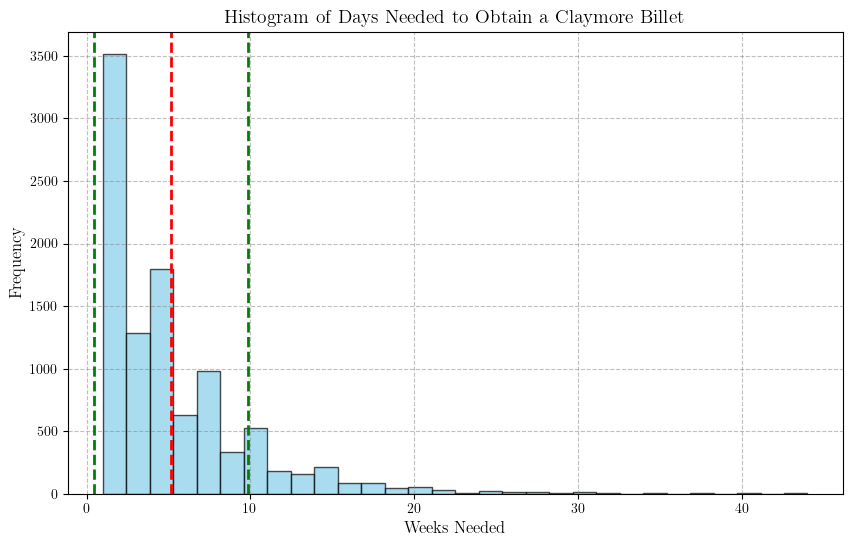

In [191]:
# Cell 4: Monte Carlo Simulation
weeks_needed_list = []

for _ in range(NUM_SIMULATIONS):
    weeks = 0
    resin_accumulated = 0
    found_claymore_billet = False
    
    while not found_claymore_billet:
        weeks += 1
        resin_accumulated += RESIN_PER_DAY * 7
        found_claymore_billet = simulate_weekly_domains(resin_accumulated, PROB_BILLET_DROP, PROB_CLAYMORE_BILLET)
        resin_accumulated = max(0, resin_accumulated - TOTAL_RESIN_NEEDED)
    
    weeks_needed_list.append(weeks)

# Descriptive statistics
average_weeks_needed = np.mean(weeks_needed_list)
average_days_needed = average_weeks_needed * 7
confidence_interval = stats.t.interval(
    0.95, len(weeks_needed_list) - 1, loc=average_days_needed, scale=stats.sem(weeks_needed_list) * 7
)
std_dev_weeks_needed = np.std(weeks_needed_list)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(weeks_needed_list, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Weeks Needed')
plt.axvline(average_weeks_needed, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {average_weeks_needed:.2f} weeks')
plt.axvline(average_weeks_needed+std_dev_weeks_needed, color='green', linestyle='dashed', linewidth=2, label=f'Mean + 1 SD: {average_weeks_needed + std_dev_weeks_needed:.2f} weeks')
plt.axvline(average_weeks_needed-std_dev_weeks_needed, color='green', linestyle='dashed', linewidth=2, label=f'Mean - 1 SD: {average_weeks_needed - std_dev_weeks_needed:.2f} weeks')
plt.ylabel('Frequency')
plt.title('Histogram of Days Needed to Obtain a Claymore Billet')
plt.grid(True)
plt.show()

In [192]:
print(f"{average_days_needed} ", f"+/- {confidence_interval[1]-confidence_interval[0]} days")

36.2278  +/- 1.29031580864455 days


So It takes anywhere from 30-40 days to get the billet you want from trounce domains! Let's continue onwards, calculating bootstrap intervals.

### Bootstraps

We calculate here a bootstrap confidence interval, comparing how this works with the data we have above. It is another method to calculate the uncertainty, this method is often employed with smaller datasets, or datasets with non-normal distributions (for example skewed data). When the bootstrap approximates normally, then we can just use normal approximation, however if this distribution is not normal, then we can use bootstrapping as an excellent, distribution-free way to calculate errors.
#### The steps of the Bootstrap method

1. Given the original dataset $\mathbf{X}=\{X_1,X_2,\ldots,X_n\}$, where the $n$ is the number of observations. We generate $B$ resampled datasets. Each resampled dataset, $\mathbf{X}_b^*$ is created by selecting $n$ observations from $\mathbf{X}$ with replacement.
2. Calculating the resampled means is done very simply by $\bar{X}_b^* = \frac{1}{n}\sum^n_{i=1}X^*_{b,i}$, which is done for all of the resampled datasets.
3. Now we estimate the confidence interval, in this case taking an $\alpha = 0.05$, by taking the upper $\alpha/2$ percentile, and the lower $1-\alpha/2$ percentile.
4. We just multiply by 7 to get our data in form of days

In [193]:
# Cell 5: Bootstrap Confidence Interval
def bootstrap_confidence_interval(data, num_resamples=1000, confidence_level=0.95):
    resampled_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(num_resamples)]
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100
    return np.percentile(resampled_means, [lower_percentile, upper_percentile])

bootstrap_ci = bootstrap_confidence_interval(weeks_needed_list)
bootstrap_ci_days = [week * 7 for week in bootstrap_ci]

bootstrap_ci_days[1]-bootstrap_ci_days[0]

1.259667499999999

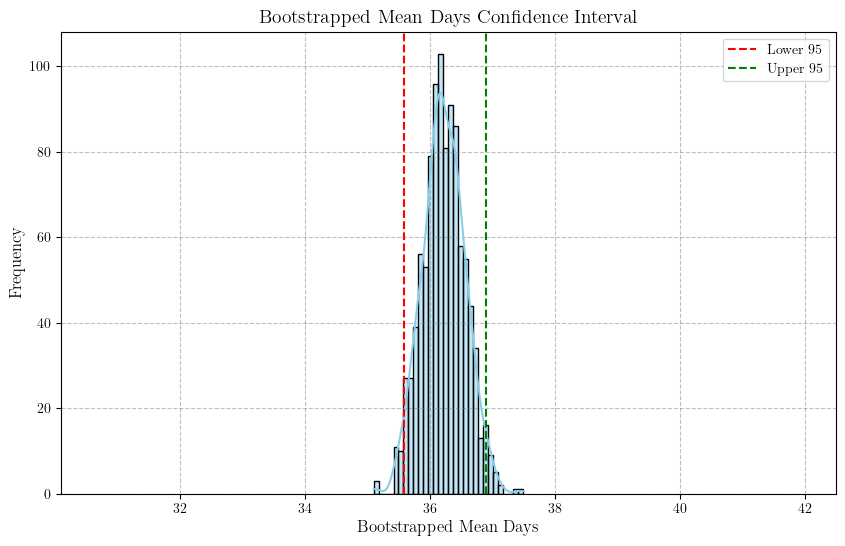

In [194]:
# Generate bootstrap samples and calculate means
num_bootstrap_samples=1000
bootstrapped_means = [
    np.mean(np.random.choice(weeks_needed_list, size=len(weeks_needed_list), replace=True))
    for _ in range(num_bootstrap_samples)
]

# Convert the weeks to days
bootstrapped_means_days = [weeks * 7 for weeks in bootstrapped_means]

# Calculate the bootstrapped confidence intervals
bootstrap_ci_lower, bootstrap_ci_upper = np.percentile(bootstrapped_means_days, [2.5, 97.5])

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(bootstrapped_means_days, bins=30, kde=True, color='skyblue')
plt.axvline(x=bootstrap_ci_lower, color='r', linestyle='--', label=f'Lower 95% CI: {bootstrap_ci_lower:.2f} days')
plt.axvline(x=bootstrap_ci_upper, color='g', linestyle='--', label=f'Upper 95% CI: {bootstrap_ci_upper:.2f} days')
plt.xlabel('Bootstrapped Mean Days')
plt.ylabel('Frequency')
plt.title('Bootstrapped Mean Days Confidence Interval')
plt.legend()
plt.xlim(min(bootstrapped_means_days) - 5, max(bootstrapped_means_days) + 5)  # Set limits to focus on the relevant range
plt.grid(True)
plt.show()


### The difference between Bootstraps and t-interval

The difference between the two types of intervals calculated here are largely the flexibility of each method. While bootstraps are extremely flexible, t-intervals are reliant on the underlying process following a normal distribution. This is true for our dataset, therefore we should continue with the t-interval. The demonstration of the bootstrap here is to show how perhaps smaller sets of data can compute a confidence interval for the average.

### Sensitivity tests

Below are very simple tests to see how sensitive the days to get a billet are with respect to the changing of certain parameters. This is done by running the simulation over a large set of parameters, below we do it for 50 parameters within 0.05-0.40.

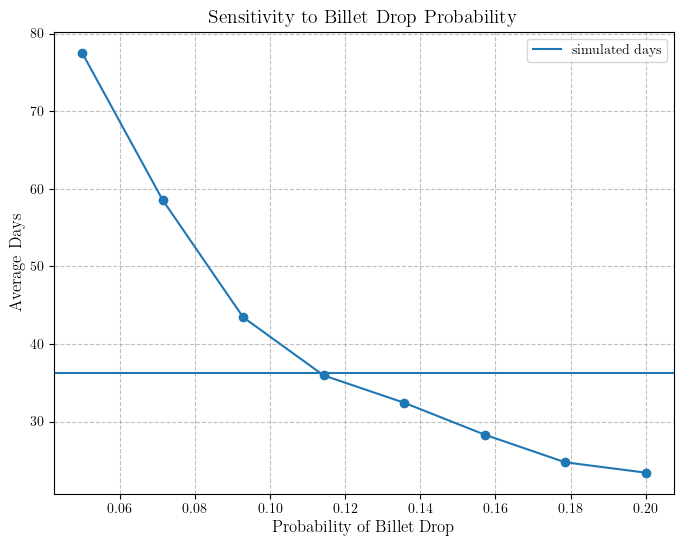

In [195]:
# Cell 6: Sensitivity Analysis for Billet Drop Probability
billet_drop_range = np.linspace(0.05, 0.2, 8)
days_vs_billet_drop = []

for billet_drop_prob in billet_drop_range:
    weeks_needed_list = []
    for _ in range(1000):  # Use consistent sample size
        weeks = 0
        resin_accumulated = 0
        found_claymore_billet = False
        while not found_claymore_billet:
            weeks += 1
            resin_accumulated += RESIN_PER_DAY * 7
            found_claymore_billet = simulate_weekly_domains(resin_accumulated, billet_drop_prob, PROB_CLAYMORE_BILLET)
            resin_accumulated = max(0, resin_accumulated - TOTAL_RESIN_NEEDED)
        weeks_needed_list.append(weeks)
    
    days_vs_billet_drop.append(np.mean(weeks_needed_list) * 7)

plt.figure(figsize=(8, 6))
plt.plot(billet_drop_range, days_vs_billet_drop, marker='o')
plt.xlabel('Probability of Billet Drop')
plt.ylabel('Average Days')
plt.axhline(average_days_needed,label = "simulated days")
plt.title('Sensitivity to Billet Drop Probability')
plt.legend()
plt.grid(True)
plt.show()


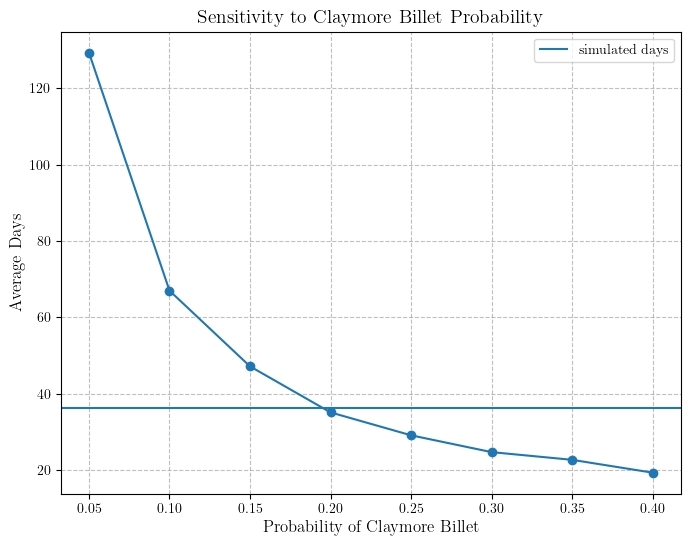

In [196]:
# Cell 7: Sensitivity Analysis for Claymore Billet Probability
claymore_billet_range = np.linspace(0.05, 0.4, 8)
days_vs_claymore_billet = []

for claymore_billet_prob in claymore_billet_range:
    weeks_needed_list = []
    for _ in range(1000):
        weeks = 0
        resin_accumulated = 0
        found_claymore_billet = False
        while not found_claymore_billet:
            weeks += 1
            resin_accumulated += RESIN_PER_DAY * 7
            found_claymore_billet = simulate_weekly_domains(resin_accumulated, PROB_BILLET_DROP, claymore_billet_prob)
            resin_accumulated = max(0, resin_accumulated - TOTAL_RESIN_NEEDED)
        weeks_needed_list.append(weeks)
    
    days_vs_claymore_billet.append(np.mean(weeks_needed_list) * 7)

plt.figure(figsize=(8, 6))
plt.plot(claymore_billet_range, days_vs_claymore_billet, marker='o')
plt.xlabel('Probability of Claymore Billet')
plt.ylabel('Average Days')
plt.axhline(average_days_needed,label = "simulated days")
plt.title('Sensitivity to Claymore Billet Probability')
plt.grid(True)
plt.legend()
plt.show()


As you can see, just small differences in the parameters can lead to very large changes in the amount of time needed to get the billet that you want!

## Contour and minimisation

We perform a polynomial regression in order to find out what billet drop probability would be optimal to minimise the number of days needed to get a target billet. This is done over a large range for the parameters:

- `billet drop probability` is ranged between 5-50%.
- `claymore drop probability` is ranged from 5-40%.
- `resin recharge time` is kept at 8 minutes/resin

The method used to minimise the the parameters is the Polynomial Regression, of order 2. So for $n$ orders, the model looks like:
$$ y = \beta_0 *+ \beta_1 x + \beta_2 x^2 + \ldots + \beta_n x^n .$$

As we consider just two orders, the model looks like: 

$$ y = \beta_0 *+ \beta_1 x + \beta_2 x^2.$$

The squared difference between our model and the target, in this case 14 days, is used. As we are minimising a quadratic objective, the method called Conjugate Gradient is used. This assumption is used due to the fact we assume to be operating around the minimum of the parameters, so the quadratic can be used as a good estimate of the minimum behaviour.

### Conjugate Gradient method, an overview.

The CG Method is used for quadratic functions as:

$$ \frac{1}{2} x^TAx + b^Tx + c$$
For matrix a, vector b and constant c.

The minimisation that CG iterates over the conjugate directions, these directions are defined by vectors $p_i,$ s.t.

$$p_i^TAp_j = 0 \;\;\forall\;\; i \neq j$$

So these two vectors $p_i$ and $p_j$ transformed by $A$, are orthogonal. This orthogonality conditions ensures that oe direction is followed for the minimisation.

The method starts guessing with some $x_0$, and calculates its residual $b-Ax_0$. This residual is set as the initial search direction. The iteration then begins as:
1. update the guess $x_{k+1}=x_k+\alpha_kp_k$, for step size $\alpha_k$, defined by: $$\alpha_k = \frac{p^T_kp_k}{p_k^TAp_k}
2. The new residual is calculated with $x_{k+1}
3. If $r_k$ is too small, end
4. Otherwise, update the search direction : $p_{k+1} = r_{k+1}+\frac{r_{k+1}^Tr_{k+1}}{r_k^Tr_k}p_k.$

This method is highly efficient, and well-suited to this problem due to its low computational complexity. Below we employ this by minimising for 100 parameters, 1000 times, averaging the output. A contour plot and 3D plot is shown for sensitivity

In [197]:
# Initialize ranges
dimensionality_minimisation = 100
billet_drop_range = np.linspace(0.05, 0.50, dimensionality_minimisation)
claymore_billet_range = np.linspace(0.05, 0.4, dimensionality_minimisation)

# Perform the optimization process over 10 runs to average results
num_runs = 1000
optimized_params_list = []
optimized_predictions_list = []

for _ in range(num_runs):
    # Simulate average_days_optimized
   

    average_days_optimized = np.random.choice(weeks_needed_list, size=(dimensionality_minimisation, dimensionality_minimisation)) * 7

    # Prepare data for regression
    X_extended = np.array([
        (bd, cb)
        for bd in billet_drop_range
        for cb in claymore_billet_range
    ])
    y_extended = average_days_optimized.flatten()

    # Perform polynomial regression

    model_extended = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    model_extended.fit(X_extended, y_extended)

    # Define objective function
    def objective_function(params, target_days=14):
        prediction = model_extended.predict([params])
        return (prediction - target_days) ** 2

    # Initial guess and bounds
    center_guess = [
        billet_drop_range.mean(),
        claymore_billet_range.mean(),
    ]
    bounds = [
        (billet_drop_range.min(), billet_drop_range.max()),
        (claymore_billet_range.min(), claymore_billet_range.max())
    ]

    # Optimize parameters
     # Suppress the RuntimeWarning when using CG
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        # Optimize parameters
        result = minimize(objective_function, center_guess, bounds=bounds, method='CG')
        optimized_params = result.x
        optimized_prediction = model_extended.predict([optimized_params])[0]

    optimized_params_list.append(optimized_params)
    optimized_predictions_list.append(optimized_prediction)


# Calculate average optimized parameters and prediction
average_optimized_params = np.mean(optimized_params_list, axis=0)
average_optimized_prediction = np.mean(optimized_predictions_list)

average_optimized_params, average_optimized_prediction

print(f"optimised billet drop rate: {average_optimized_params[0]:.2f}")
print(f"optimised chosen billet drop rate: {average_optimized_params[1]:.2f}")
print(f"optimised days: {average_optimized_prediction:.2f}")

optimised billet drop rate: 0.28
optimised chosen billet drop rate: 0.27
optimised days: 14.84


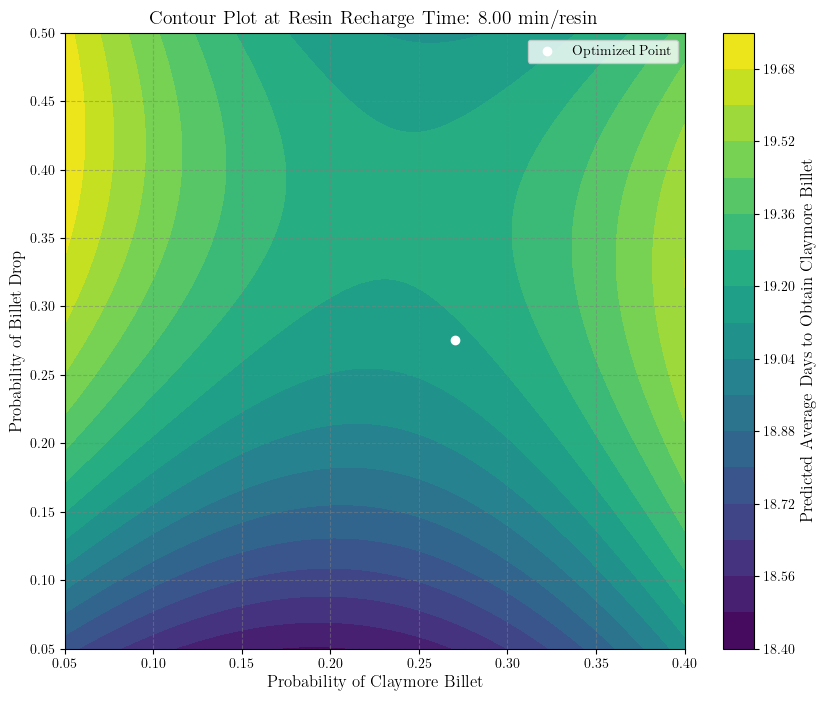

In [198]:
# Use the optimized resin recharge time for the prediction
optimized_resin_recharge_time = 8

prediction_grid_optimized = model_extended.predict(
    np.array([(bd, cb) for bd in billet_drop_range for cb in claymore_billet_range])
).reshape(len(billet_drop_range), len(claymore_billet_range))

# Create the contour plot

plt.figure(figsize=(10, 8))
contour = plt.contourf(
    claymore_billet_range, billet_drop_range, prediction_grid_optimized,
    cmap='viridis', levels=20
)
plt.colorbar(contour, label='Predicted Average Days to Obtain Claymore Billet')
plt.xlabel('Probability of Claymore Billet')
plt.ylabel('Probability of Billet Drop')
plt.title(f'Contour Plot at Resin Recharge Time: {8:.2f} min/resin')

# Highlight the optimized point
plt.scatter(average_optimized_params[1], average_optimized_params[0], color='white', marker='o', label='Optimized Point')
plt.legend()
plt.xlim([claymore_billet_range.min(), claymore_billet_range.max()])
plt.ylim([billet_drop_range.min(), billet_drop_range.max()])
plt.show()


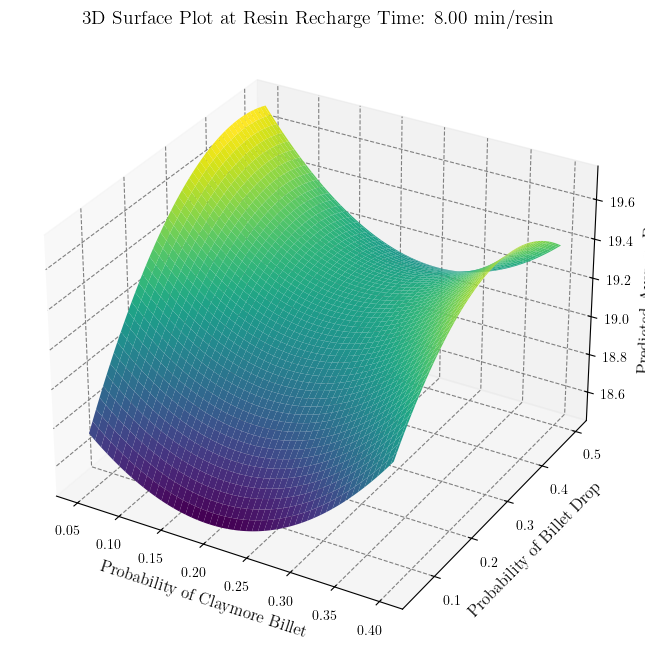

In [199]:
# Create a 3D surface plot of the predicted average days needed

from mpl_toolkits.mplot3d import Axes3D

# Prepare the meshgrid for claymore_billet_range and billet_drop_range
X, Y = np.meshgrid(claymore_billet_range, billet_drop_range)

# Create a 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(X, Y, prediction_grid_optimized, cmap='viridis', edgecolor='none')

# Add color bar and labels
ax.set_xlabel('Probability of Claymore Billet')
ax.set_ylabel('Probability of Billet Drop')
ax.set_zlabel('Predicted Average Days')
ax.set_title(f'3D Surface Plot at Resin Recharge Time: {8.0:.2f} min/resin')

plt.show()


The variability in contour plots with each run is largely due to the stochastic nature of the simulation data used to generate them. This simulation involves randomly selecting values from weeks_needed_list to estimate the average number of days required to obtain a claymore billet. Each run introduces different random samples, which affect the predicted outcomes and result in changes in the contour shapes

### Remarks

The number of days on average found to be $~36.0 \pm 1$ days, due to the stochastic nature of the simulation, you may need to refer to the top cells in the notebook to see theresults, along with a $1\sigma$ interval. The bootstrap method was demonstrated, as well as a polynomial fit to minimise the data to see what would cause the average to go down to 14 days.

## Sources
[1] https://gamerant.com/genshin-impact-artifact-bosses-domain-drop-rate/#:~:text=Meanwhile%2C%20for%20Genshin%20Impact%27s%20Prototype,every%208-9%20Weekly%20Boss.